This is the group project notebook!

**HI KAI, EMMA, AND ANNIE!!!**

**Proposed specific question:** does played_hours influence whether or not people subscribe?
Can we predict whether or not someone will subscribe to the newsletter based on how much they've played in Plaicraft?

In [57]:
library(tidyverse)
library(repr)
options(repr.matrix.max.rows = 6)
library(ggplot2)
library(tidymodels)
library(dplyr)
library(themis)

**Data Reading:**

In [2]:
players <- read_csv("data/players.csv")
sessions <- read_csv("data/sessions.csv")
players

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
⋮,⋮,⋮,⋮,⋮,⋮,⋮
Amateur,FALSE,d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb,0.0,Dylan,Prefer not to say,17
Amateur,FALSE,f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436,2.3,Harlow,Male,17
Pro,TRUE,d9473710057f7d42f36570f0be83817a4eea614029ff90cf50d8889cdd729d11,0.2,Ahmed,Other,NA


In [3]:
mod_players <- players |>
                select (subscribe, played_hours, experience) |>
                mutate (subscribe = as_factor(subscribe),
                        experience = recode(experience, Beginner = 1, Amateur = 2, Regular = 3, Pro = 4, Veteran = 5)) 
mod_players

subscribe,played_hours,experience
<fct>,<dbl>,<dbl>
TRUE,30.3,4
TRUE,3.8,5
FALSE,0.0,5
⋮,⋮,⋮
FALSE,0.0,2
FALSE,2.3,2
TRUE,0.2,4


In [44]:
tf_list <- players |>
            select (subscribe) |>
            summarise (true_count = sum(subscribe, na.rm = TRUE), 
                         false_count = sum(!subscribe, na.rm = TRUE))
tf_list

true_count,false_count
<int>,<int>
144,52


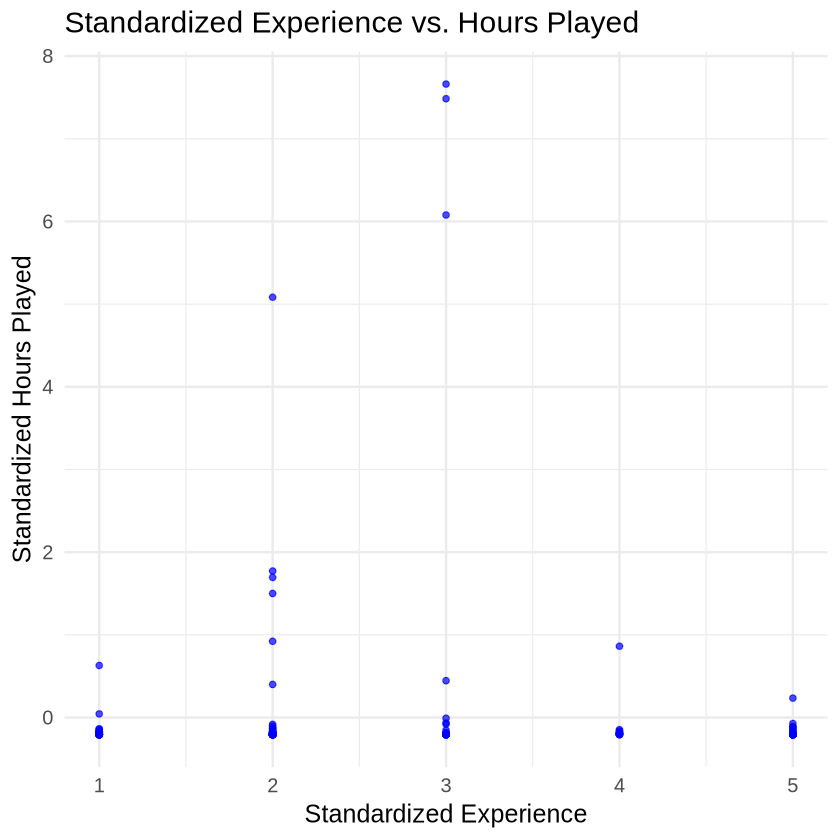

In [4]:
recipe_standardized <- recipe(~ experience + played_hours, data = mod_players) |>
    step_scale(played_hours) |>   
  step_center(played_hours) |>  
  prep() 

# Apply transformation
mod_players_scaled <- bake(recipe_standardized, new_data = mod_players)

ggplot(mod_players_scaled, aes(x = experience, y = played_hours)) +
  geom_point(alpha = 0.7, color = "blue") +  
  labs(title = "Standardized Experience vs. Hours Played",
       x = "Standardized Experience",
       y = "Standardized Hours Played") +
  theme_minimal(base_size = 15)  

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
2,accuracy,binary,0.482266,5,0.03113068,Preprocessor1_Model01
2,roc_auc,binary,0.500286,5,0.05027122,Preprocessor1_Model01
4,accuracy,binary,0.489179,5,0.02111987,Preprocessor1_Model02
⋮,⋮,⋮,⋮,⋮,⋮,⋮
48,roc_auc,binary,0.4586155,5,0.081305835,Preprocessor1_Model24
50,accuracy,binary,0.7348276,5,0.004190282,Preprocessor1_Model25
50,roc_auc,binary,0.4451183,5,0.048973364,Preprocessor1_Model25


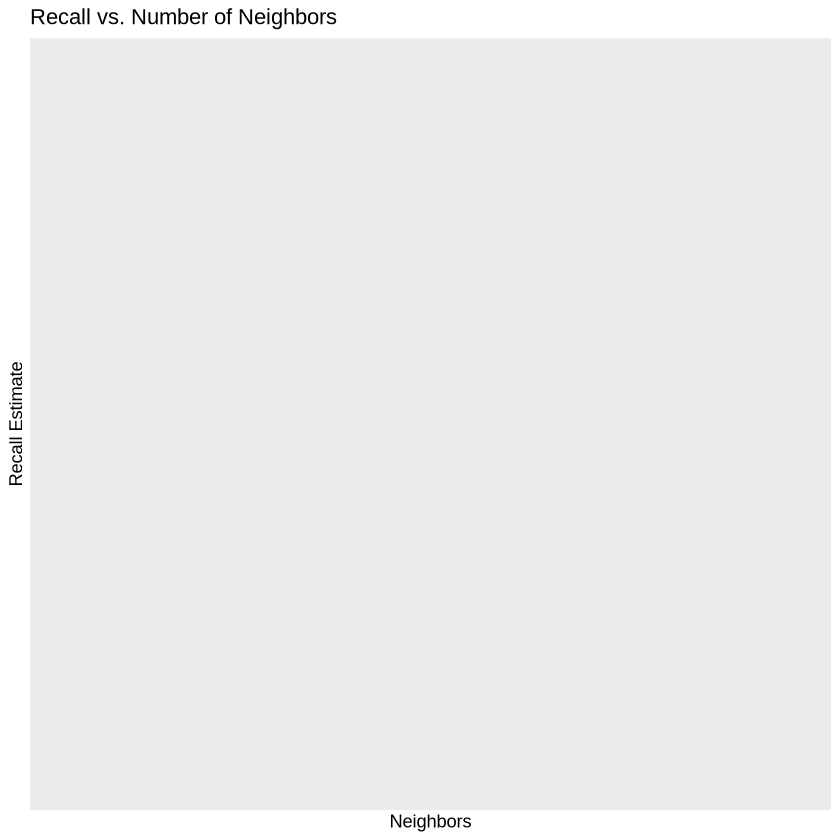

In [55]:
# K-nn Tuning
set.seed(12)
players_split <- mod_players |> 
                    initial_split (prop = 0.75, strata = subscribe) 

players_training <- training (players_split)
players_testing <- testing (players_split)

recipe_with_step <- recipe(subscribe ~ ., data = players_training) |>
                        step_center(all_predictors()) |>
                        step_scale(all_predictors())

knn_spec_tune <- nearest_neighbor (weight_func = "rectangular", neighbors = tune()) |>
                    set_engine("kknn") |>
                    set_mode ("classification")

vfold <- vfold_cv(players_training, v = 5, strata = subscribe)

knn_grid <- tibble(neighbors = seq(from = 2, to = 50, by = 2))

knn_results <- workflow() |>
                  add_recipe(recipe_with_step) |>
                  add_model(knn_spec_tune) |>
                  tune_grid(resamples = vfold, grid = knn_grid)|>
                  collect_metrics()

knn_results

# Plot recall vs. number of neighbors
recall_plot <- ggplot(recalls, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(x = "Neighbors", 
       y = "Recall Estimate",
       title = "Recall vs. Number of Neighbors") 

recall_plot

# # Fix issue with extracting neighbors and mean accuracy
# accuracies <- knn_results |>
#                   filter(.metric == "accuracy") |>
#                   select(neighbors, mean = mean) |>  # Ensure correct column selection
#                   mutate(neighbors = as.numeric(neighbors), mean = as.numeric(mean))

# # Plot accuracy vs. number of neighbors
# cross_val_plot <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
#                   geom_point() +
#                   geom_line() +
#                   labs(x = "Neighbors", 
#                        y = "Accuracy Estimate") 
             

# cross_val_plot

In [59]:
# Optimal K for testing 
optimal_k <- 5

spec <- nearest_neighbor(weight_func = "rectangular", neighbors = optimal_k) |>
            set_engine("kknn") |>
            set_mode("classification")

fit <- workflow() |>
                add_recipe (recipe_with_step) |>
                add_model (spec) |>
                fit(data = players_training)

predictions <- predict (fit, new_data = players_testing) |>
                bind_cols (players_testing)

metrics <- predictions |>
            metrics(truth = subscribe, estimate = .pred_class)

conf_mat <- predictions |>
                conf_mat (truth = subscribe, estimate = .pred_class)

metrics 
conf_mat

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.4693878
recall,binary,0.5384615


          Truth
Prediction FALSE TRUE
     FALSE     7   20
     TRUE      6   16

## how to move on from here
- instead of accuracies, we can test out recall, precision
- or we can even try out step_upsample
- 

In [60]:
## Recall

# Compute recall
recall_value <- predictions |>
            recall(subscribe, estimate = .pred_class)
recall_value

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
recall,binary,0.5384615


In [61]:
## Precision
# Compute precision
precision_value <- predictions |>
            precision(subscribe, estimate = .pred_class)
precision_value

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
precision,binary,0.2592593


In [62]:
## Upsample
recipe_with_step_up <- recipe(subscribe ~ ., data = players_training) |>
                        step_center(all_predictors()) |>
                        step_scale(all_predictors()) |>
                        step_upsample (subscribe , over_ratio = 1) 

fit2 <- workflow() |>
                add_recipe (recipe_with_step_up) |>
                add_model (spec) |>
                fit(data = players_training)

predictions2 <- predict (fit2, new_data = players_testing) |>
                bind_cols (players_testing)

metrics2 <- predictions2 |>
            metrics(truth = subscribe, estimate = .pred_class)

conf_mat <- predictions2 |>
                conf_mat (truth = subscribe, estimate = .pred_class)

metrics 
conf_mat

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.4693878
recall,binary,0.5384615


          Truth
Prediction FALSE TRUE
     FALSE    11   28
     TRUE      2    8

In [ ]:
## RSME